## NYC Taxi Traffic Analysis

The following script needs to be uncommented if the packges in the package_list have not yet been installed.

In [4]:
# !pip install --upgrade pip
# package_list = ['bs4', 'seaborn', 'numpy', 'pandas', 'sklearn', 'statsmodels', 'geopy']
# for x in package_list:
#     !pip install {x}

In [1]:
import bs4 as bs
import urllib
import seaborn as sb
import numpy as np
import pandas as pd
from pyspark.sql.functions import col,unix_timestamp
from pyspark import StorageLevel

import matplotlib.pyplot as plt
import os
import warnings

In [2]:
%matplotlib notebook

In [3]:
warnings.filterwarnings('ignore')
sc.setCheckpointDir('checkpointfolder')
spark.conf.set("spark.yarn.appMasterEnv.SPARK_HOME","/usr/lib/spark")

### Task 1
#### $*$ Programmatically download and load into your favorite analytical tool the trip data for September 2015.

1. I will download the September 2015 green taxi data to TripData Folder on hdfs. This data will be used for tackling Task 1,2 and 3.

2. I will download all the green taxi data for 2015, 1016 and 2017, and save them in folders TripData15, TripData16 and TripData17 separately. The three years' data will be used to tackle Task 4 and 5. 

In [5]:
def download_data(data_spec_dict, create_hdfs_folder=False, hdfs_folder_name='TripData'):
    url = 'http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml'
    sauce = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(sauce, 'html5lib')
    test_values = lambda url, d : True if all([x in url for x in d.values()]) else False
    links_to_download = [url['href'] for url in soup.find_all('a') \
                        if test_values(url['href'], data_spec_dict)]
    
    file_names = []
    for link in links_to_download:
        fname = os.path.basename(link)
        file_names.append(fname)
        urllib.request.urlretrieve(link, fname)
    print('Successfully downloaded {} to driver node.'.format(file_names))
    
    if create_hdfs_folder:
        !hadoop fs -mkdir {hdfs_folder_name}
    for x in file_names:
        !hadoop fs -put {x} {hdfs_folder_name}
    print('Succesfully uploaded {} to hdfs.'.format(file_names))
    
    return file_names

In [67]:
data_spec_dict = {
    'color': 'green',
    'year': '2015',
    'month': '09'
}
file_names = download_data(data_spec_dict, True, 'TripData')

Successfully downloaded ['green_tripdata_2015-09.csv'] to driver node.
17/12/05 07:24:26 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/05 07:24:28 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
Succesfully uploaded ['green_tripdata_2015-09.csv'] to hdfs.


In [20]:
data_spec_dict_2015 = {
    'color': 'green',
    'year': '2015'
}
file_names_2015 = download_data(data_spec_dict_2015, True, 'TripData15')

Successfully downloaded ['green_tripdata_2015-01.csv', 'green_tripdata_2015-02.csv', 'green_tripdata_2015-03.csv', 'green_tripdata_2015-04.csv', 'green_tripdata_2015-05.csv', 'green_tripdata_2015-06.csv', 'green_tripdata_2015-07.csv', 'green_tripdata_2015-08.csv', 'green_tripdata_2015-09.csv', 'green_tripdata_2015-10.csv', 'green_tripdata_2015-11.csv', 'green_tripdata_2015-12.csv'] to driver node.
17/12/03 22:17:55 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:17:57 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:18:01 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:18:05 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:18:08 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:18:12 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:18:16 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:18:21 

#### $*$ Report how many rows and columns of data you have loaded.

The size of the data 'green_tripdata_2015-09.csv' is only 228MB. I will use pandas, numpy, scipy, sklearn, etc for data exploration. (See my solutions for Task 1, 2, 3.) However, for ETL and predictive modeling, I will use pyspark, which makes the ETL and modeling solutions scalable for larger data sizes. (See my solutions for Task 4, 5.)

In [69]:
df = pd.read_csv('green_tripdata_2015-09.csv')
print('There are {} rows and {} columns of the data I have loaded.'.format(df.shape[0], df.shape[1]))

There are 1494926 rows and 21 columns of the data I have loaded.


In [70]:
# The following delete all the green_tripdata_2015* files from the driver node.
!rm green_tripdata_2015*

### Task 2
#### $*$ Plot a histogram of the number of the trip distance ("Trip Distance").

In [71]:
plt.style.use('seaborn')
plt.rcParams["patch.force_edgecolor"] = True

<IPython.core.display.Javascript object>


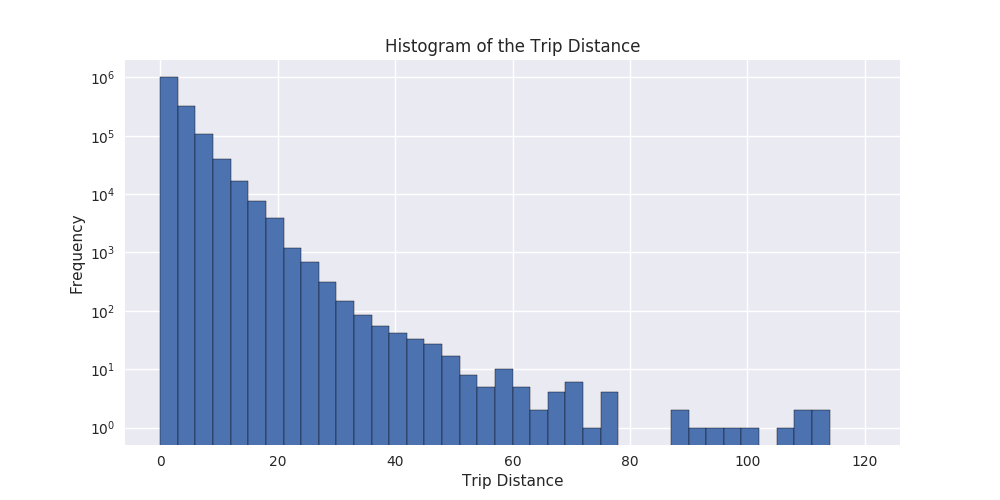

In [72]:
plt.figure(figsize=[10,5])
res = plt.hist(df.Trip_distance, log=True, bins=40, range=[0,120])
plt.title('Histogram of the Trip Distance')
plt.ylabel('Frequency')
plt.xlabel('Trip Distance')
plt.show()

From this histogram, we can find that overwelmingly large number of trips are short trips (Trip Distance <= 20 miles).

#### $*$ Report any structure you find and any hypotheses you have about that structure.

In below, I first use the normalized histogram for Trip Distance to visualize the Probability Density Function (PDF) of Trip Distance.

In [73]:
def highlight(res):
    y, edges, _ = res
    centers = (edges[1:]+edges[:-1])/2
    plt.plot(centers, y, '.', color='red')

<IPython.core.display.Javascript object>


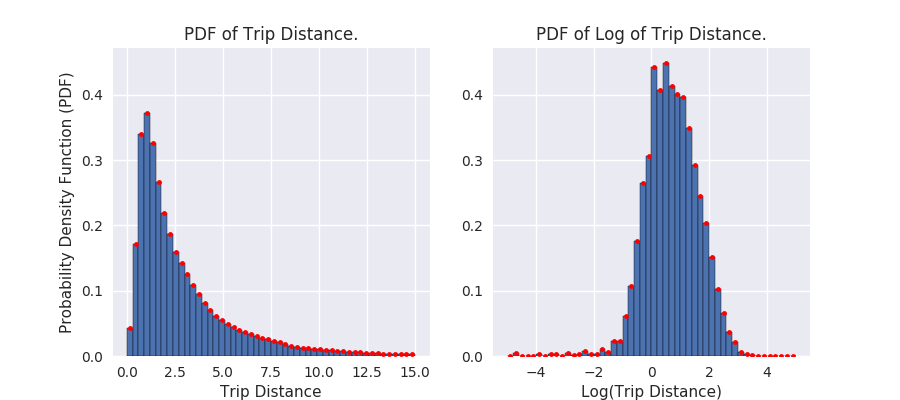

In [74]:
Trip_distance = df.Trip_distance[df.Trip_distance>0]
plt.figure(figsize=[9,4])
a1 = plt.subplot(121)
plt.title('PDF of Trip Distance.')
plt.ylabel('Probability Density Function (PDF)')
plt.xlabel('Trip Distance')
res1 = plt.hist(Trip_distance, bins=50, range=[0,15], density=True, alpha=1)
highlight(res1)
a2 = plt.subplot(122, sharey=a1)
plt.title('PDF of Log of Trip Distance.')
plt.xlabel('Log(Trip Distance)')
res2 = plt.hist(np.log(Trip_distance), bins=50, range=[-5,5], density=True, alpha=1)
highlight(res2)
plt.show()

The visualization of the PDF of Trip_distance shows a long tail on the right, whereas the Log(Trip_distance) shows a normal distribution. My hypothesis is that the PDF of Trip_distance variable follows a lognormal distribution.

To mathematically prove that lognormal distribution is better than others for fitting the PDF of Trip_distance, we can use the maximum likelihood method. The candidate distributions include: [lognormal, gamma, normal]. The following code will: 

* first, find the Maximul Likelihood Estimation (MLE) of the parameters for each distribution.
* second, report the LogLikelihood, etc for each fitted distribution. 
* third, plot the fitted distribution against the normalized histogram of Trip Distance. 

In [75]:
import scipy.stats as stats
from statsmodels.base.model import GenericLikelihoodModel
class Gamma(GenericLikelihoodModel):
    def loglike(self, params):
        return stats.gamma.logpdf(self.endog, *params).sum()
class Normal(GenericLikelihoodModel):
    def loglike(self, params):
        return stats.norm.logpdf(self.endog, *params).sum()
class Lognormal(GenericLikelihoodModel):
    def loglike(self, params):
        return stats.lognorm.logpdf(self.endog, *params).sum()

<IPython.core.display.Javascript object>


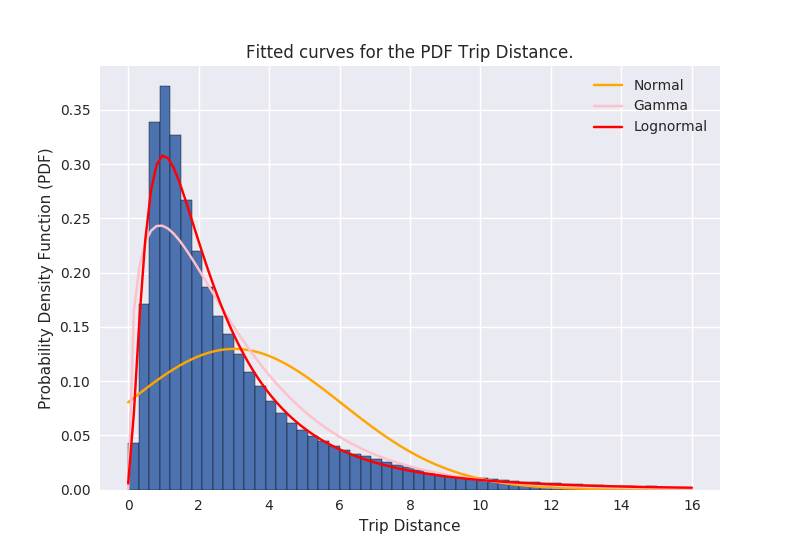

Optimization terminated successfully.
         Current function value: 2.543163
         Iterations: 77
         Function evaluations: 144
The fitted parameters (loc, scale) for Normal distribution are: [ 3.0096192   3.07784849].
LogLikelihood: -3749471.530593694.

Optimization terminated successfully.
         Current function value: 2.065096
         Iterations: 98
         Function evaluations: 172
The fitted parameters (a, loc, scale) for Gamma distribution are: [ 1.42252893  0.00706427  2.11070156].
LogLikelihood: -3044640.5459938943.

Optimization terminated successfully.
         Current function value: 2.019537
         Iterations: 99
         Function evaluations: 176
The fitted parameters (s, loc, scale) for Lognormal distribution are: [ 0.82656832 -0.10733056  2.20574068].
LogLikelihood: -2977472.6544469716.



In [103]:
def fit_distributions(y):
    plt.figure() 
    x = np.linspace(0,16, 100)
    dist_dict = {
        'Lognormal': {'module': [Lognormal, stats.lognorm], 
                      'color': 'red', 
                      'params': [1, 0, 1],
                      'param_names':'s, loc, scale'},
        'Gamma': {'module': [Gamma, stats.gamma], 
                  'color': 'pink', 
                  'params': [1, 0, 1],
                  'param_names':'a, loc, scale'},
        'Normal': {'module': [Normal, stats.norm], 
                   'color': 'orange', 
                   'params': [0, 1],
                   'param_names':'loc, scale'}
    }
    
    plot_res_list = []
    for k,v in dist_dict.items():
        res = v['module'][0](y).fit(v['params'])
        print('The fitted parameters ({}) for {} distribution are: {}.'\
              .format(v['param_names'], k, res.params))
        print('LogLikelihood: {}.\n'.format(res.llf))
        
        pdf_fitted = v['module'][1].pdf(x, *res.params)
        plot_res, = plt.plot(x, pdf_fitted, '-', color=v['color'], label=k)
        plot_res_list.append(plot_res)
        
        
    res1 = plt.hist(y, bins=50, range=[0,15], density=True, alpha=1)
    plt.legend(handles=plot_res_list)
    plt.title('Fitted curves for the PDF Trip Distance.')
    plt.xlabel('Trip Distance')
    plt.ylabel('Probability Density Function (PDF)')
    plt.show()

y = df.Trip_distance[df.Trip_distance>0]
fit_distributions(y)

From the above figure, it is obvious that lognormal distribution fits Trip_distance PDF the best. Now, let's compare the Log-Likelihood: 

In [77]:
sorted([-3749471.530593694, -3044640.5459938943, -2977472.6544469716])

[-3749471.530593694, -3044640.5459938943, -2977472.6544469716]

In other words, LogLikelihood_Normal < LogLikelihood_Gamma < LogLikelihood_Lognormal. This means lognormal distribution fits the distribution of Trip_distance the best.

### Task 3

#### $*$ Report mean and median trip distance grouped by hour of day.

In [78]:
df2 = df[['lpep_pickup_datetime','Lpep_dropoff_datetime','Trip_distance']]
df2['lpep_pickup_datetime'] = pd.to_datetime(df2['lpep_pickup_datetime'])
df2['Lpep_dropoff_datetime'] = pd.to_datetime(df2['Lpep_dropoff_datetime'])

In [79]:
df2['Hour_of_day'] = ((df2['Lpep_dropoff_datetime'] - df2['lpep_pickup_datetime'])/2 
                        + df2['lpep_pickup_datetime']).map(lambda x: x.hour)
del df2['lpep_pickup_datetime'],df2['Lpep_dropoff_datetime']

In [80]:
df2.head()

,Trip_distance,Hour_of_day
0,0.00,0
1,0.00,0
2,0.59,0
3,0.74,0
4,0.61,0


In [81]:
df2[['Trip_distance', 'Hour_of_day']].groupby('Hour_of_day').agg([np.mean, np.median])

Trip_distance       
                     mean median
Hour_of_day                     
0                3.183713   2.24
1                3.062710   2.16
2                3.092803   2.19
3                3.206705   2.22
4                3.517394   2.38
5                4.117403   2.84
6                3.936409   2.78
7                3.253702   2.10
8                2.993109   1.92
9                3.021705   1.98
10               2.965888   1.95
11               2.888889   1.87
12               2.916823   1.90
13               2.876131   1.85
14               2.814014   1.80
15               2.819248   1.80
16               2.786065   1.80
17               2.690497   1.77
18               2.673889   1.80
19               2.721500   1.85
20               2.783274   1.90
21               2.967810   2.01
22               3.173241   2.18
23               3.207370   2.24

#### $*$ We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

LaGuardia Airport should be the airport we are interested in. From the center of the Laguadia Airport (40.776927 N, 73.873966 W), we can draw a circle with a radius of 0.8. All the trips that end within this circle will be considered trips that terminate at Larguadia Airport, and all the trips originate from within this circle will be considered trips that originate from Larguadia Airport. 

In [82]:
from geopy.distance import great_circle
airport_loc = (40.776927, -73.873966)
r = 0.8

In [83]:
df['airport_trip'] = [great_circle(airport_loc, (x[0],x[1])).miles < 0.8 or \
                       great_circle(airport_loc, (x[2],x[3])).miles < 0.8 \
                    for x in zip(df.Pickup_latitude, df.Pickup_longitude, df.Dropoff_latitude, df.Dropoff_longitude)]

In [84]:
print('1. There are {} trips that either originate or terminate at LaGuardia Airport.'.format(df.airport_trip.sum()))

1. There are 21689 trips that either originate or terminate at LaGuardia Airport.


In [85]:
airport_trips = df[df.airport_trip==True]
average_fair = airport_trips['Total_amount'].mean()
print('2. The average fare for the airport trips is {} USD.'.format(average_fair))

2. The average fare for the airport trips is 24.617526395868875 USD.


The below gives the statistics of the Trip_distance of airport trips (for Laguardia Airport). It shows that the median trip distance is 4.93 mile, whereas the max trip distance is 246.38 mile, quite a long distance!

In [86]:
airport_trips['Trip_distance'].describe()

count    21689.000000
mean         5.865225
std          3.739787
min          0.000000
25%          3.100000
50%          4.930000
75%          8.090000
max        246.280000
Name: Trip_distance, dtype: float64

In addition, I am also interested in the number of trips originate/terminate at the airport as grouped by hour of day.

In [87]:
airport_trips['lpep_pickup_datetime'] = pd.to_datetime(airport_trips['lpep_pickup_datetime'])
airport_trips['Lpep_dropoff_datetime'] = pd.to_datetime(airport_trips['Lpep_dropoff_datetime'])
airport_trips['Hour_of_day'] = ((airport_trips['Lpep_dropoff_datetime'] - airport_trips['lpep_pickup_datetime'])/2 
                        + airport_trips['lpep_pickup_datetime']).map(lambda x: x.hour)

<IPython.core.display.Javascript object>


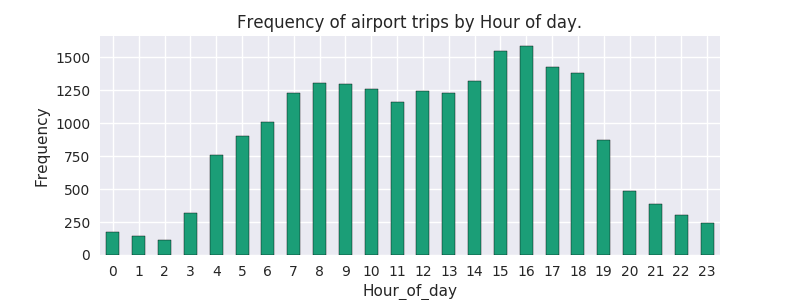

In [104]:
plt.figure()
airport_trips['Hour_of_day'].value_counts().sort_index().plot(kind='bar', figsize=(8,3), rot=0, colormap='Dark2')
plt.gcf().subplots_adjust(bottom=0.15)
plt.title('Frequency of airport trips by Hour of day.')
plt.xlabel('Hour_of_day')
plt.ylabel('Frequency')
plt.show()

The above figure shows that, during the morning 8am-10am and afternoon 2pm-6pm, there are a lot of green taxi trips that transports passengers between NYC local area and Laguardia Airport (airport_trip_freq>1250). Also, it shows that there are more airport trips in afternoons than in mornings. In addition, we can find that there are many airport trips in the early morning (4am-6am). This may be explained that many people call taxi for early departures/arrivals. 

Now, let's count the number of airport trips for each value of the Passenger_count variable:

In [89]:
airport_trips['Passenger_count'].value_counts()

1    18100
2     1724
5      969
3      431
6      312
4      148
0        5
Name: Passenger_count, dtype: int64

The above statistics show that one-passenger trips are much more frequent than multi-passenger trips. 

In [90]:
airport_trips['Payment_type'].value_counts()

1    13556
2     8080
4       34
3       18
5        1
Name: Payment_type, dtype: int64

The counts of each Payment_type categories show that among airport trip passengers, the most common payment type is credit card (Payment_type=1), and the second most common payment type is cash (Payment_type=2). Payment types such as 'No charge' (Payment_type=3), 'Dispute' (Payment_type=4) and 'Unknown' (Payment_type=5) rarely happen but still exist.

### Task 4

#### $*$ Build a derived variable for tip as a percentage of the total fare.

     Tip_perc = Tip_amount / Total_amount.
     
Since variables Tip_amount and Total_amount are used to generate the labels, we should skip these two variables when building features.

#### $*$ Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.

I will use pyspark to build the model. There are four steps I will do for building the model.
  
1. Feature Engineering.
2. Splitting the data into training and test set.
3. Predctive modeling and model evaluation.

#### 1. Feature Engineering.

In below, I use the Septempber 2015 green taxi data for feature engineering.

In [91]:
!hadoop fs -ls TripData

17/12/05 07:34:48 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
Found 1 items
-rw-r--r--   2 root hadoop  239035648 2017-12-05 07:24 TripData/green_tripdata_2015-09.csv


In [31]:
print(file_names)
df = spark.read.csv(*['TripData/'+x for x in file_names], 
                    inferSchema=True, 
                    header=True)

# we need rename the column 'Trip_type ' into 'Trip_type' for ease of running queries at a later time.
df = df.withColumnRenamed('Trip_type ' ,'Trip_type')

df.cache() # df will be persisted into the memory after the first action.
print('There are {} records in the df.'.format(df.count()))

['green_tripdata_2015-09.csv']
There are 1494926 records in the df.


In [33]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- Lpep_dropoff_datetime: timestamp (nullable = true)
 |-- Store_and_fwd_flag: string (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- Pickup_longitude: double (nullable = true)
 |-- Pickup_latitude: double (nullable = true)
 |-- Dropoff_longitude: double (nullable = true)
 |-- Dropoff_latitude: double (nullable = true)
 |-- Passenger_count: integer (nullable = true)
 |-- Trip_distance: double (nullable = true)
 |-- Fare_amount: double (nullable = true)
 |-- Extra: double (nullable = true)
 |-- MTA_tax: double (nullable = true)
 |-- Tip_amount: double (nullable = true)
 |-- Tolls_amount: double (nullable = true)
 |-- Ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- Total_amount: double (nullable = true)
 |-- Payment_type: integer (nullable = true)
 |-- Trip_type : integer (nullable = true)



The above prints the schema of the pyspark dataframe, where we can find the type of the data as automatically infered upon loading from hdfs.

In [34]:
df.describe().toPandas().head(10)

,summary,VendorID,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,count,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,1494926,0,1494926,1494926,1494926,1494922
1,mean,1.7820447299732562,None,1.0976529941950304,-73.83083949411842,40.69114448571891,-73.83727771386073,40.69290536073598,1.370597608175923,2.9681408511191236,12.543197516131206,0.35127996302158104,0.4866408103143567,1.2357267048665443,0.1231046620367582,None,0.2920990737969791,15.03214575175613,1.540558529318508,1.022353005708659
2,stddev,0.4128569780371028,None,0.6359437498154663,2.7760817734036745,1.530881939832038,2.6779113552401093,1.4766981108136834,1.0394261428126599,3.076620809359895,10.082781124002889,0.3663096455583607,0.08504472979388217,2.431475965084631,0.891013678344865,None,0.05074009373082956,11.55315515785043,0.5232934633632245,0.14782883163593222
3,min,1,N,1,-83.31907653808594,0.0,-83.42784118652344,0.0,0,0.0,-475.0,-1.0,-0.5,-50.0,-15.29,None,-0.3,-475.0,1,1
4,max,2,Y,99,0.0,43.17726135253906,0.0,42.79934310913086,9,603.1,580.5,12.0,0.5,300.0,95.75,None,0.3,581.3,5,2


There are several discoveries from the above table. 

a. The first row is checking the number of non-null values for each variable. It is obvious that 'Ehail_fee' is an empty column. Except for this column, none of other columns have missing values (their count=1494926).
    
    This means we need to skip 'Ehail_fee' for our modeling, and check if the missing values are represented by 
    other values in the rest of the columns.

b. There are unreasonable zero values in the column: 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Trip_distance'.
    
    We can check the records with 0.0s in some of these columns:

In [58]:
df\
    .select(['Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Trip_distance'])\
    .where((col('Pickup_longitude')==0.0) | (col('Trip_distance')==0.0))\
    .sample(False, 500/1494926, 112233)\
    .show()

+------------------+------------------+------------------+------------------+-------------+
|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Trip_distance|
+------------------+------------------+------------------+------------------+-------------+
| -73.9542465209961|40.800933837890625|-73.94195556640625|40.824729919433594|          0.0|
|               0.0|               0.0| -73.9476547241211|40.816993713378906|         0.01|
|-73.86770629882812|40.745033264160156|-73.86776733398438| 40.74500274658203|          0.0|
|               0.0|               0.0|-73.86204528808594| 40.76865005493164|         11.6|
|               0.0|               0.0| -73.8769302368164| 40.82360076904297|         0.03|
| -73.9582290649414| 40.66347885131836| -73.9582290649414| 40.66347885131836|          0.0|
|-73.86483764648438| 40.77036666870117|-73.86485290527344|40.770362854003906|          0.0|
|-73.99115753173828|40.671260833740234|-73.99114990234375| 40.67127227783203|   

In [59]:
df_len = df.count()
td_zero_pt = df.select('Trip_distance').where(col('Trip_distance')==0).count() / df_len * 100
pl_zero_pt = df.select('Pickup_longitude').where(col('Pickup_longitude')==0).count() / df_len * 100
dl_zero_pt = df.select('Dropoff_longitude').where(col('Dropoff_longitude')==0).count() / df_len * 100
print('Percentage of zero values for Trip_distance, Pickup_longitude and Dropoff_longitude are:\n{}'\
      .format([td_zero_pt,pl_zero_pt, dl_zero_pt]))

Percentage of zero values for Trip_distance, Pickup_longitude and Dropoff_longitude are:
[1.3774594862889533, 0.14114411014324454, 0.1313108474934545]


    Now it is obvious that for the 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 
    columns 0.0 represents missing value. Since the ranges of latitude and longitude of NYC will never cover 0.0, 
    we can keep 0.0 as the missing value for 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 
    'Dropoff_latitude' safely. 
    
    It also can be found that for 'Trip_distance', 0.0 represents either missing value or zero distance. Since only
    1.38% of total records have zeros, I will remove all the records with 0.0 in the Trip_distance column.

c. There are unreasonable negative values in column: 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge' and 'Total_amount'.

In [60]:
df.select(['Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Total_amount'])\
    .filter(col('Total_amount')<0).toPandas().sample(10)

,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount
2254,-20.0,-1.0,0.0,0.0,0.0,-0.3,-21.3
1872,-2.5,-1.0,-0.5,0.0,0.0,-0.3,-4.3
958,-5.0,-0.5,-0.5,0.0,0.0,-0.3,-6.3
1173,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8
2037,-4.5,-0.5,-0.5,0.0,0.0,-0.3,-5.8
1893,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8
1476,-4.5,-1.0,-0.5,0.0,0.0,-0.3,-6.3
1305,-2.5,-1.0,-0.5,0.0,0.0,-0.3,-4.3
1115,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8
1595,-4.0,-0.5,-0.5,0.0,0.0,-0.3,-5.3


    It is obvious that these records are assoicated to refunds. We should remove these records all together as well.

* After understanding the data, we can generate the features with existing variables and derived variables. 

The existing variables that will be used as features include: [VendorID, Passenger_count, RateCodeID, Payment_type, Store_and_fwd_flag, Fare_amount, Extra, MTA_tax, Improvement_surcharge, Tolls_amount, Trip_distance, Pickup_longitude, Pickup_latitude, Dropoff_longitude, Dropoff_latitude], 15 in total. 

Among these 15 variables, [VenderID, RateCodeID, Payment_type, Store_and_fwd_flag] are categorical variables, here in the query I manually convert them from double/integer types to the string type. When pyspark dataframe have string columns, each string column will be automiatically converted into columns of dummy variables (by one-hot encoding), once it is used to create a RFormula instance (see the following section for details).

* We can also generate new features such as:


1. Pickup_hour (from lpep_pickup_datetime)
2. Pickup_dayofweek (from lpep_pickup_datetime)
3. Trip_duration (from lpep_pickup_datetime and Lpep_dropoff_datetime)
4. Trip_speed (from lpep_pickup_datetime, Lpep_dropoff_datetime, Trip_distance)

The following transformation query generates not only the feature columns but also the label column. 

In [25]:
def step0_transfm(df, df_view_name):
    data_transformation_query = """
    SELECT 
        CAST(VendorID AS STRING), 
        Passenger_count, 
        CAST(RateCodeID AS STRING), 
        CAST(Payment_type AS STRING), 
        CAST(Store_and_fwd_flag AS STRING),
        Fare_amount, 
        Extra, 
        MTA_tax, 
        Improvement_surcharge, 
        Tolls_amount, 
        Trip_distance, 
        Pickup_longitude, 
        Pickup_latitude, 
        Dropoff_longitude, 
        Dropoff_latitude,

        HOUR(lpep_pickup_datetime) AS Pickup_hour,
        CAST(date_format(lpep_pickup_datetime, 'u') AS INTEGER) AS Pickup_dayofweek,
        unix_timestamp(Lpep_dropoff_datetime) - unix_timestamp(lpep_pickup_datetime) AS Trip_duration, 

        100*Tip_amount/Total_amount AS Tip_perc
    FROM 
        {}
    WHERE 
        Payment_type IN (1,2)
        AND Trip_distance>0 AND Tip_amount>=0 AND Total_amount>0
        AND Fare_amount>=0 AND Extra>=0 AND MTA_tax>=0 AND Tolls_amount>=0 AND improvement_surcharge>=0
    """
    df.createOrReplaceTempView(df_view_name)
    res = spark\
        .sql(data_transformation_query.format(df_view_name))\
        .withColumn('Trip_speed', 3600*col('Trip_distance')/col('Trip_duration'))\
        .where(col('Trip_duration')>0)\
        .na.fill(-9999)
    spark.catalog.dropTempView(df_view_name)
    return res

From above, we find that all the variables are numeric, but some of them are integer-encoded representing categorical variables. Tree models such as Gradient Boosting Trees and Random Forest are actually capable of handling these categorical variables when coded with integers. However, I will still convert them back to categorical variables (using cast(_ as string)), hoping to alleviate some learning burden during the model fitting process.

#### 2. Splitting the data into training and test set.  

For training the model, I will use the odd-month green taxi data from 2015. I will then split the 2015 data into training and test parts. The traning part will take 85% of the original dataset.

In [111]:
!hadoop fs -ls -h TripData15
print('The total size of of data before splitting is: {}GB'.format((232.0+265.6+275.9+235.0+228.0+233.3)/1024))

17/12/05 08:14:04 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
Found 12 items
-rw-r--r--   2 root hadoop    232.0 M 2017-12-03 22:17 TripData15/green_tripdata_2015-01.csv
-rw-r--r--   2 root hadoop    242.7 M 2017-12-03 22:18 TripData15/green_tripdata_2015-02.csv
-rw-r--r--   2 root hadoop    265.6 M 2017-12-03 22:18 TripData15/green_tripdata_2015-03.csv
-rw-r--r--   2 root hadoop    256.8 M 2017-12-03 22:18 TripData15/green_tripdata_2015-04.csv
-rw-r--r--   2 root hadoop    275.9 M 2017-12-03 22:18 TripData15/green_tripdata_2015-05.csv
-rw-r--r--   2 root hadoop    252.9 M 2017-12-03 22:18 TripData15/green_tripdata_2015-06.csv
-rw-r--r--   2 root hadoop    235.0 M 2017-12-03 22:18 TripData15/green_tripdata_2015-07.csv
-rw-r--r--   2 root hadoop    233.7 M 2017-12-03 22:18 TripData15/green_tripdata_2015-08.csv
-rw-r--r--   2 root hadoop    228.0 M 2017-12-03 22:18 TripData15/green_tripdata_2015-09.csv
-rw-r--r--   2 root hadoop    248.7 M 2017-12-03 22:18 TripData15

In [19]:
file_names_2015=['green_tripdata_2015-01.csv',  'green_tripdata_2015-03.csv',  'green_tripdata_2015-05.csv', 
                 'green_tripdata_2015-07.csv', 'green_tripdata_2015-09.csv', 'green_tripdata_2015-11.csv']
file_names_2015= ['TripData15/'+x for x in file_names_2015]
print(file_names_2015)

df = spark.read.csv(file_names_2015, inferSchema=True, header=True)
df = df.withColumnRenamed('Trip_type ' ,'Trip_type')

train_raw, test_raw = df.randomSplit(weights=[0.85, 0.15], seed=1234)

['TripData15/green_tripdata_2015-01.csv', 'TripData15/green_tripdata_2015-03.csv', 'TripData15/green_tripdata_2015-05.csv', 'TripData15/green_tripdata_2015-07.csv', 'TripData15/green_tripdata_2015-09.csv', 'TripData15/green_tripdata_2015-11.csv']


In [21]:
train_transformed = step0_transfm(train_raw, 'train_raw')
train_transformed.persist(StorageLevel(True, True, False, False, 1))
train_transformed.count() # materialize the caching

7963542

In [22]:
test_transformed = step0_transfm(test_raw,'test_raw')
test_transformed.persist(StorageLevel(True, True, False, False, 1))
test_transformed.count() # materialize the caching

1405184

#### 3. Predctive modeling and model evaluation.

First, I would like to build a Gradient Boosting Regression model for tip as a percentage of the total fare.

In [26]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import RFormula
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
import time

In [27]:
sc.setCheckpointDir('checkpointfolder')
colns = train_transformed.columns
colns.remove('Tip_perc')
print('The features include:')
print(*[str(i)+'. '+colns[i] for i in range(len(colns))], sep='\n')

The features include:
0. VendorID
1. Passenger_count
2. RateCodeID
3. Payment_type
4. Store_and_fwd_flag
5. Fare_amount
6. Extra
7. MTA_tax
8. Improvement_surcharge
9. Tolls_amount
10. Trip_distance
11. Pickup_longitude
12. Pickup_latitude
13. Dropoff_longitude
14. Dropoff_latitude
15. Pickup_hour
16. Pickup_dayofweek
17. Trip_duration
18. Trip_speed


In [68]:
rformula = RFormula(formula = 'Tip_perc ~ ' + ' + '.join(colns))
gmr = GBTRegressor(featuresCol='features', 
                   maxIter=80,
                   maxDepth=5,
                   stepSize=0.0375,
                   subsamplingRate=0.8
                  )
pipleline_model = Pipeline(stages=[rformula, gmr]).fit(train_transformed)

predictions = pipleline_model.transform(test_transformed)

predictionAndLabels = predictions.select('label','prediction').rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = {}".format(testMetrics.rootMeanSquaredError))

pipleline_model.save('gs://c1-0/pipleline_model_maxIter80_maxDepth5_stepSize00375_subsamplingRate08')

RMSE = 4.860401016451925


The best Gradient Boosting Regression model that I found after tuning is: 

    maxIter=80, maxDepth=5, stepSize=0.0375, subsamplingRate=0.8, with RMSE = 4.860401016451925

Before training this model, I've also tried other combinations of hyper parameters, such as:

1. model-1: maxIter=2, maxDepth=3, stepSize=0.033333, subsamplingRate=0.666666.
2. model-2: maxIter=20, maxDepth=5, stepSize=0.1, subsamplingRate=0.65.
3. model-3: maxIter=20, maxDepth=5, stepSize=0.1, subsamplingRate=1.

With approximately 1.22 GB (1.43535GB * 0.85) data in hand, I found the evaluation metric does not improve too much after increasing the complexity of the gradient boosting model from the model-1 to the current pipeline-model. This might just because we don't have very informative features, for example the weather, or customer's mood and personality. Another problem is that, unlike tensorflow, I didn't find that pyspark.ml package offers the opportunity to checkpoint a model while training. Without the knowledge where is the balance point between under-fitting and over-fitting, we might end up with models either with under-fitting or over-fitting. Since Random Forest model is more robust to over-fitting, I would like a try:

In [46]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', 
                           numTrees=64,
                           maxDepth=14, 
                           subsamplingRate=0.65,
                           featureSubsetStrategy = "onethird"
                  )

pipleline_rf = Pipeline(stages=[rformula, rf])
pipleline_model_rf = pipleline_rf.fit(train_transformed)

predictions_rf = pipleline_model_rf.transform(test_transformed)
predictionAndLabels_rf = predictions_rf.select('label','prediction').rdd
testMetrics_rf = RegressionMetrics(predictionAndLabels_rf)
print("RMSE = %s" % testMetrics_rf.rootMeanSquaredError)

pipleline_model_rf.save('gs://c1-0/pipleline_model_rf_numTrees64_maxDepth14_subsamplingRate065')

RMSE = 4.796305606298888


The evaluation metric indicates that a Random Forest model with 64 trees (14 layers maximum) is indeed better than the Gradient Boosting model with 80 trees (5 layers maximum). And I will offer the saved Random Forest model for validation. If given more time, I will do a grid search to find the best hyperparameters for the Random Forest model, using split validation for each combination of hyper-parameter values. Also, if given more vCPUs and more memory, I would like to further increase the maximum depth of the tree in the Random Forest model. 

In the following top 10 important features for this model are given.

In [72]:
# The pyspark.ml.feature's one-hot encoding is a drop-last encoding, thus the level 'Group ride' is droped 
# when generating the dummy variables for RateCodeID. The order of the RateCodeID_* variables is obtained by
# looking up the data dictionary: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
colns = ['VendorID','Passenger_count','RateCodeID_Standard rate','RateCodeID_JFK','RateCodeID_Newark',
         'RateCodeID_Nassau or Wetchester','RateCodeID_Negotiated fare','Payment_type','Store_and_fwd_flag',
         'Fare_amount','Extra','MTA_tax','Improvement_surcharge', 'Tolls_amount', 'Trip_distance', 'Pickup_longitude', 
         'Pickup_latitude','Dropoff_longitude', 'Dropoff_latitude', 'Pickup_hour', 'Pickup_dayofweek', 'Trip_duration', 
         'Trip_speed']

In [73]:
FI_table = pd.DataFrame({'Feature':colns, 'Feature_Importance':pipleline_model_rf.stages[1].featureImportances })
FI_table.sort_values(['Feature_Importance'], ascending = False).head(10)

,Feature,Feature_Importance
7,Payment_type,0.877410
17,Dropoff_longitude,0.030724
15,Pickup_longitude,0.020679
16,Pickup_latitude,0.015798
18,Dropoff_latitude,0.013733
9,Fare_amount,0.013178
14,Trip_distance,0.007213
22,Trip_speed,0.004705
21,Trip_duration,0.003828
3,RateCodeID_JFK,0.002021


The following is the code to do predictions and evaluations with the saved model.

In [8]:
from pyspark.ml import PipelineModel
from pyspark.mllib.evaluation import RegressionMetrics

def step0_transfm(df, df_view_name):
    data_transformation_query = """
    SELECT 
        CAST(VendorID AS STRING), 
        Passenger_count, 
        CAST(RateCodeID AS STRING), 
        CAST(Payment_type AS STRING), 
        CAST(Store_and_fwd_flag AS STRING),
        Fare_amount, 
        Extra, 
        MTA_tax, 
        Improvement_surcharge, 
        Tolls_amount, 
        Trip_distance, 
        Pickup_longitude, 
        Pickup_latitude, 
        Dropoff_longitude, 
        Dropoff_latitude,

        HOUR(lpep_pickup_datetime) AS Pickup_hour,
        CAST(date_format(lpep_pickup_datetime, 'u') AS INTEGER) AS Pickup_dayofweek,
        unix_timestamp(Lpep_dropoff_datetime) - unix_timestamp(lpep_pickup_datetime) AS Trip_duration, 

        100*Tip_amount/Total_amount AS Tip_perc
    FROM 
        {}
    WHERE 
        Payment_type IN (1,2)
        AND Trip_distance>0 AND Tip_amount>=0 AND Total_amount>0
        AND Fare_amount>=0 AND Extra>=0 AND MTA_tax>=0 AND Tolls_amount>=0 AND improvement_surcharge>=0
    """
    df.createOrReplaceTempView(df_view_name)
    res = spark\
        .sql(data_transformation_query.format(df_view_name))\
        .withColumn('Trip_speed', 3600*col('Trip_distance')/col('Trip_duration'))\
        .where(col('Trip_duration')>0)\
        .na.fill(-9999)
    spark.catalog.dropTempView(df_view_name)
    return res

def prediction_func(paths_of_csvs, path_of_pipeline_model):
    test_df = spark.read.csv(paths_of_csvs, inferSchema=True, header=True)
    test_df = test_df.withColumnRenamed('Trip_type ' ,'Trip_type')
    
    test_df_transformed = step0_transfm(test_df, 'test_df')
    
    pipleline_model = PipelineModel.load(path_of_pipeline_model)
    test_df_predictions = pipleline_model.transform(test_df_transformed)
    
    return test_df_predictions.select('label','prediction')#test_df_predictions

def evaluation_func(prediction_df):
    test_predictionAndLabels = prediction_df.rdd
    test_Metrics = RegressionMetrics(test_predictionAndLabels)
    print("RMSE = {}".format(test_Metrics.rootMeanSquaredError))
    
test_df_predictions = prediction_func(['TripDataAll/green_tripdata_2016-05.csv'],
                    'gs://c1-0/pipleline_model_rf_numTrees64_maxDepth14_subsamplingRate065')

In [9]:
evaluation_func(test_df_predictions)

RMSE = 5.033076186840986


### Task 5 

#### Anomaly Detection
#### $*$ What anomalies can you find in the data? Did taxi traffic or behavior deviate from the norm on a particular day/time or in a particular location?

If we count the total number of green taxi pickups/dropoffs every 15 minutes in a day, we can obtain the pattern of taxi traffic for the given day. Since we have weekdays and weekends, there might be two major taxi traffic patterns in existence. However, for certain holidays or big events in New York, the green taxi traffic pattern can be drastically different.

Here I would like to find in which days and in which 15-minute intervals there are anomalies regarding the total number of pickups, using all the green taxi data.

In [22]:
def download_all():
    file_names = []
    for year in range(2013,2018):
        if year == 2013:
            create_folder = True
        else:
            create_folder = False
        file_names.append(download_data({'color': 'green', 'year': str(year)}, 
                                        create_folder, 
                                        'TripDataAll')
                         )
        !rm green_tripdata*
    return file_names

file_names = download_all()

Successfully downloaded ['green_tripdata_2013-08.csv', 'green_tripdata_2013-09.csv', 'green_tripdata_2013-10.csv', 'green_tripdata_2013-11.csv', 'green_tripdata_2013-12.csv'] to driver node.
17/12/03 22:19:42 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:19:44 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:19:47 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:19:50 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:19:53 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
17/12/03 22:19:55 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
Succesfully uploaded ['green_tripdata_2013-08.csv', 'green_tripdata_2013-09.csv', 'green_tripdata_2013-10.csv', 'green_tripdata_2013-11.csv', 'green_tripdata_2013-12.csv'] to hdfs.
Successfully downloaded ['green_tripdata_2014-01.csv', 'green_tripdata_2014-02.csv', 'green_tripdata_2014-03.csv', 'green_tripdata

In [95]:
!hadoop fs -du -s -h TripDataAll

17/12/05 07:37:23 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.1-hadoop2
7.9 G  TripDataAll


#### $*$ Using time-series analysis, clustering, or some other method, please develop a process/methodology to identify out of the norm behavior and attempt to explain why those anomalies occurred.

I will go through the following steps for this anormaly detection task:
1. Data loading and transformation (which include creation of the time series data of the total number of pickups for every 15 minutes).
2. Choose the stable period of the time series data and create sequences with a moving window.
3. Use KMeans clustering algorithm to cluster the sequences generated in 2. (Best number of clusters will be found using the elbow plot).
4. Use the centroids of the clusters to reconstruct the stable period of the original time series.
5. Do anomaly detection with the reconstructed time series and the original time series.

In [10]:
def load_data(folder_name, file_names):
    
    file_name_paths = [folder_name + '/' + item for sublist in file_names for item in sublist]
    input_df = spark.read.csv(file_name_paths, header=True)\
    .filter(col('Trip_distance')>0)\
    .select(col('lpep_pickup_datetime').cast('timestamp').alias('pickup_timestamp'))

    input_df.persist(StorageLevel(True, True, False, False, 1))
    print('There are {} records in the loaded dataset(s).'.format(input_df.count()))
    
    input_df.createOrReplaceTempView('input_df')
    ts_data = spark.sql("""
    SELECT
        FROM_UNIXTIME(ts_key*15*60) AS start_timestamp, pickup_ct
    FROM
        (
        SELECT FLOOR(UNIX_TIMESTAMP(pickup_timestamp)/(15 * 60)) AS ts_key, COUNT(*) AS pickup_ct
        FROM input_df
        GROUP BY ts_key
        )
    ORDER BY start_timestamp
    """).toPandas()
    input_df.unpersist()
    
    ts_data.set_index(pd.DatetimeIndex(ts_data['start_timestamp']), inplace = True)
    del ts_data['start_timestamp']
    idx = pd.date_range(ts_data.index[0], ts_data.index[-1], freq='15min' )
    ts_data = ts_data.reindex(idx, fill_value=0)
    
    return ts_data

In [12]:
file_names=[['green_tripdata_2013-08.csv', 'green_tripdata_2013-09.csv', 'green_tripdata_2013-10.csv', 'green_tripdata_2013-11.csv', 'green_tripdata_2013-12.csv'] ,
['green_tripdata_2014-01.csv', 'green_tripdata_2014-02.csv', 'green_tripdata_2014-03.csv', 'green_tripdata_2014-04.csv', 'green_tripdata_2014-05.csv', 'green_tripdata_2014-06.csv', 'green_tripdata_2014-07.csv', 'green_tripdata_2014-08.csv', 'green_tripdata_2014-09.csv', 'green_tripdata_2014-10.csv', 'green_tripdata_2014-11.csv', 'green_tripdata_2014-12.csv'] ,
['green_tripdata_2015-01.csv', 'green_tripdata_2015-02.csv', 'green_tripdata_2015-03.csv', 'green_tripdata_2015-04.csv', 'green_tripdata_2015-05.csv', 'green_tripdata_2015-06.csv', 'green_tripdata_2015-07.csv', 'green_tripdata_2015-08.csv', 'green_tripdata_2015-09.csv', 'green_tripdata_2015-10.csv', 'green_tripdata_2015-11.csv', 'green_tripdata_2015-12.csv'] ,
['green_tripdata_2016-01.csv', 'green_tripdata_2016-02.csv', 'green_tripdata_2016-03.csv', 'green_tripdata_2016-04.csv', 'green_tripdata_2016-05.csv', 'green_tripdata_2016-06.csv', 'green_tripdata_2016-07.csv', 'green_tripdata_2016-08.csv', 'green_tripdata_2016-09.csv', 'green_tripdata_2016-10.csv', 'green_tripdata_2016-11.csv', 'green_tripdata_2016-12.csv'] ,
['green_tripdata_2017-01.csv', 'green_tripdata_2017-02.csv', 'green_tripdata_2017-03.csv', 'green_tripdata_2017-04.csv', 'green_tripdata_2017-05.csv', 'green_tripdata_2017-06.csv'] ]

In [13]:
tsdata = load_data('TripDataAll', file_names)

There are 37833551 records in the loaded dataset(s).


In [14]:
tsdata.describe()

,pickup_ct
count,136855.000000
mean,276.449900
std,249.147687
min,0.000000
25%,13.000000
50%,256.000000
75%,461.000000
max,2258.000000


In the following I will use pandas dataframe to do data analysis. 

<IPython.core.display.Javascript object>


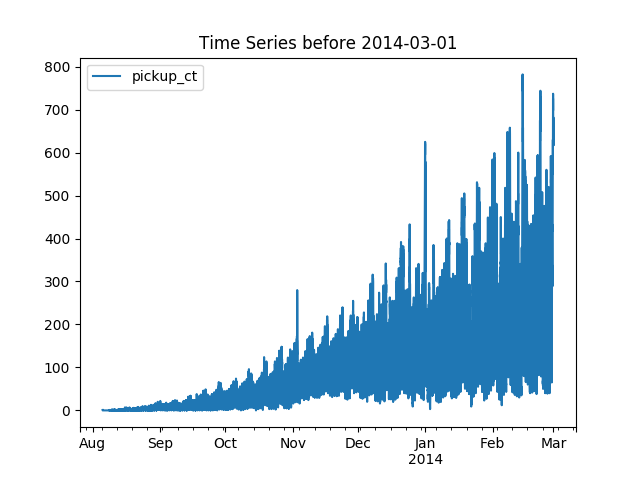

In [15]:
tsdata[:'2014-03-01 00:00:00'].plot(title='Time Series before 2014-03-01')

The pickup_ct data collected before '2014-03-01' has not reaching the stable stage. I would like to delete them from my analysis.

In [16]:
tsdata2 = tsdata['2014-03-01 00:00:00':]

<IPython.core.display.Javascript object>


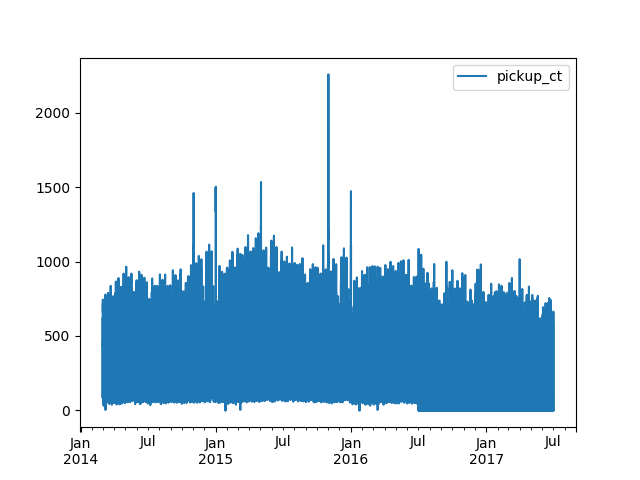

In [17]:
tsdata2.plot()

In [19]:
def sequence_list_gen(s, sequence_len, offset):
    sequence_list = []
    for i in range(0, len(s), offset):
        sequence = s[i:i+sequence_len]
        if len(sequence) == sequence_len:
            sequence_list.append(sequence)

    return sequence_list

sequence_list = sequence_list_gen(tsdata2.pickup_ct, 96, 2)
print("%d sequences are generated." % len(sequence_list))

58417 sequences are generated.


In [20]:
def window_transform(sequences, sequence_len):
    window_x = np.linspace(0, np.pi, sequence_len)
    window = np.sin(window_x)**2 # Hann window

    windowed_seqs = []
    for sequence in sequences:
        windowed_seq = np.copy(sequence) * window
        windowed_seqs.append(windowed_seq)
        
    return windowed_seqs

sequence_list_w = window_transform(sequence_list, 96)

In [21]:
from sklearn.cluster import KMeans

wiss_list = []
clusterers = []

# Note: The following loop may take a long time to complete.
for k in range(48,6*48,48):
    test_clusterer = KMeans(n_clusters=k).fit(sequence_list_w)
    clusterers.append(test_clusterer)
    wiss_list.append(test_clusterer.inertia_)

<IPython.core.display.Javascript object>


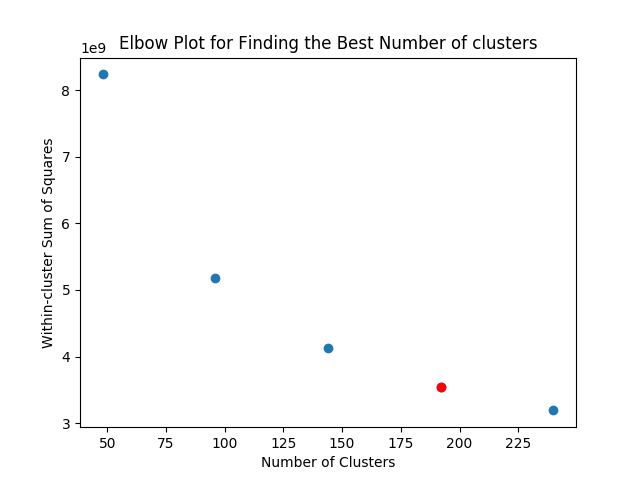

In [22]:
k_range=list(range(48,6*48,48))
plt.figure()
plt.scatter(k_range, wiss_list)
plt.scatter(k_range[3], wiss_list[3], color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.title('Elbow Plot for Finding the Best Number of clusters')
plt.show()

In [429]:
k_range

[48, 96, 144, 192, 240]

In [23]:
# According to the elbow plot, I choose 192 as the best number of clusters.
clusterer = clusterers[3]

<IPython.core.display.Javascript object>


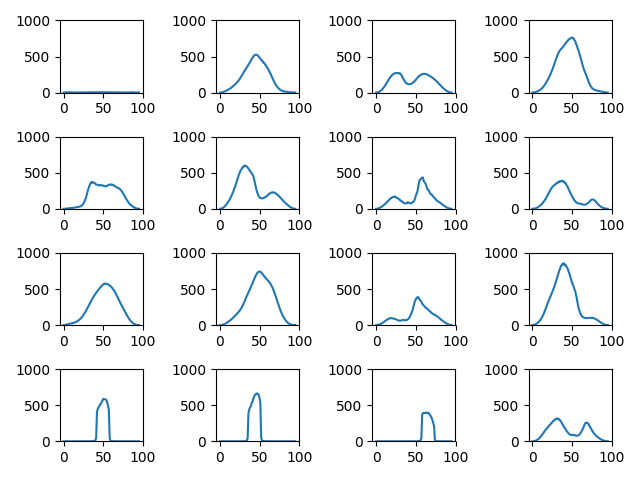

In [24]:
def plot_sequences(sequence_list, nrows, ncols, step):
    
    plt.figure()
    subplot_i = 1
    sequence_j = 0
    
    for _ in range(nrows):
        for _ in range(ncols):
            axes = plt.subplot(nrows, ncols, subplot_i)
            axes.set_ylim([0, 1000])
            seq = sequence_list[sequence_j]
            plt.plot(seq)
            subplot_i += 1
            sequence_j += step
    
    plt.tight_layout()
    plt.show()

plot_sequences(clusterer.cluster_centers_, 4,4, step=1)

In [26]:
def sequence_concat(raw_sequence, sequence_len):
    seq_list = sequence_list_gen(raw_sequence, 
                                 sequence_len=sequence_len, 
                                 offset=sequence_len)
    
    seq_list_w = window_transform(seq_list, sequence_len)
    nearest_centroid_ids = clusterer.predict(seq_list_w)
    nearest_centroids = clusterer.cluster_centers_[nearest_centroid_ids]
    seqs_w_flat = np.array(seq_list_w).reshape(-1)
    nearest_centroids_flat = nearest_centroids.reshape(-1)
    
    return seqs_w_flat, nearest_centroids_flat

seq_w_flat, centroids_flat = sequence_concat(tsdata2.pickup_ct, 96)

<IPython.core.display.Javascript object>


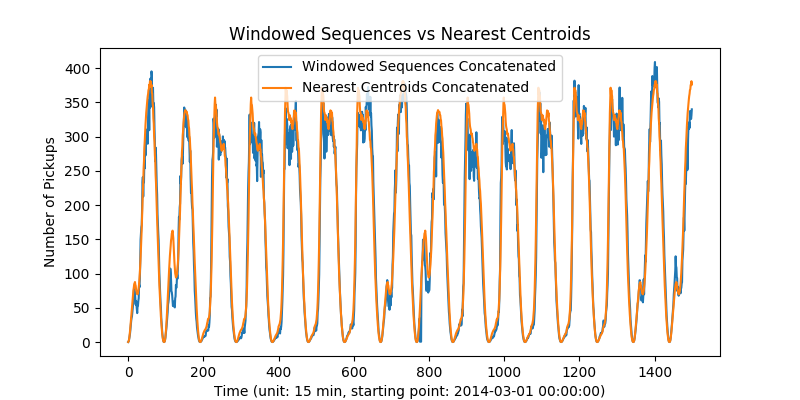

In [27]:
plt.figure(figsize=[8,4])
plt.plot(seq_w_flat[0:1500], label="Windowed Sequences Concatenated")
plt.plot(centroids_flat[0:1500], label="Nearest Centroids Concatenated")
plt.xlabel('Time (unit: 15 min, starting point: 2014-03-01 00:00:00)')
plt.ylabel('Number of Pickups')
plt.title('Windowed Sequences vs Nearest Centroids')
plt.legend()
plt.show()

In [30]:
def sequence_reconstruct(raw_sequence, sequence_len):
    
    offset = int(sequence_len/2)
    seq_list = sequence_list_gen(raw_sequence, 
                                 sequence_len=sequence_len, 
                                 offset=offset)
    
    seq_list_w = window_transform(seq_list, sequence_len)
    tot_len = len(seq_list_w)*sequence_len
    nearest_centroid_ids = clusterer.predict(seq_list_w)
    nearest_centroids = clusterer.cluster_centers_[nearest_centroid_ids]
    
    reconstr_seq = np.zeros(len(raw_sequence) + offset)
    for i in range(len(seq_list_w)):
        reconstr_seq[i*offset:i*offset+sequence_len]+=\
        nearest_centroids[i]
    
    return reconstr_seq

reconstr_seq = sequence_reconstruct(tsdata2.pickup_ct, 96)

<IPython.core.display.Javascript object>


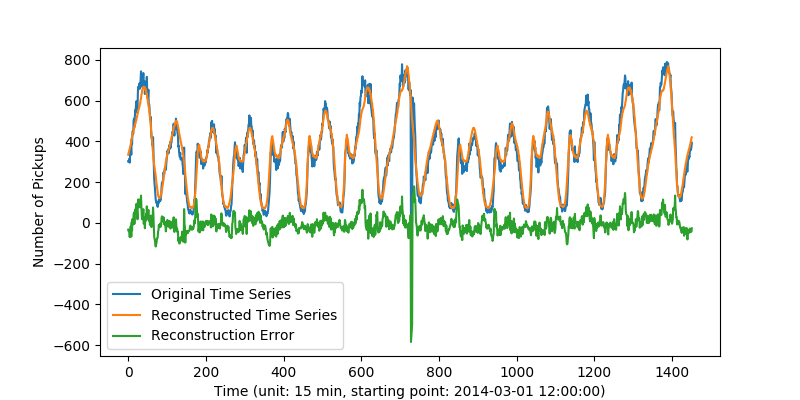

In [49]:
start = 48
n_plot_samples = 1500

ts_orig = np.array(tsdata2.pickup_ct[start:n_plot_samples])
ts_rcst = reconstr_seq[start:n_plot_samples]
error = ts_orig - ts_rcst

plt.figure(figsize=[8,4])
plt.plot(ts_orig, label="Original Time Series")
plt.plot(ts_rcst, label="Reconstructed Time Series")
plt.plot(error, label="Reconstruction Error")
plt.xlabel('Time (unit: 15 min, starting point: 2014-03-01 12:00:00)')
plt.ylabel('Number of Pickups')
plt.legend()
plt.show()

In [53]:
def anomaly_detection(ts_df, reconstr_seq, offset):
    
    start = offset
    end = ts_df.shape[0]-offset
    rctr_ary = reconstr_seq[start:end]
    ts_ary = np.array(ts_df.pickup_ct)[start:end]
    error = ts_ary - rctr_ary 

    anomaly_df = pd.DataFrame({'orig_ts': ts_ary,
                               'rctr_ts': rctr_ary,
                               'error': error
                              },
                              index=ts_df.index[start:end])

    h_percentile = np.percentile(anomaly_df.error, 99.99)
    l_percentile = np.percentile(anomaly_df.error, 0.01)
    print("The Min, Max of errors are ({}, {})."\
          .format(anomaly_df.error.min(), anomaly_df.error.max()))
    print("The 0.01th, 99.99th percentile of errors are ({}, {})."\
          .format(l_percentile, h_percentile))
    too_few = anomaly_df[anomaly_df.error < l_percentile]
    too_many = anomaly_df[anomaly_df.error > h_percentile]
    
    return anomaly_df, too_few, too_many

anomaly_df, too_few_pickups, too_many_pickups = anomaly_detection(tsdata2, reconstr_seq, 48)

The Min, Max of errors are (-634.2445575542413, 904.5190358407506).
The 0.01th, 99.99th percentile of errors are (-517.3692675681119, 417.3792139556364).


#### a. The too-few-pickups anomaly.

In [51]:
too_few_pickups

,error,orig_ts,rctr_ts
2014-03-09 02:00:00,-584.193717,6,590.193717
2014-03-09 02:15:00,-551.606546,6,557.606546
2014-03-09 02:30:00,-527.368304,5,532.368304
2014-12-31 23:45:00,-547.400121,684,1231.400121
2015-03-08 02:00:00,-634.244558,4,638.244558
2015-03-08 02:15:00,-603.140271,3,606.140271
2015-03-08 02:30:00,-581.167169,4,585.167169
2015-03-08 02:45:00,-549.207984,6,555.207984
2015-05-03 00:30:00,-572.328522,833,1405.328522
2016-03-13 02:00:00,-563.628991,5,568.628991


(1) The day-light-saving will make one hour not in existence in March each year, causing the count of pickups in that hour very close to zero. (The number should be zero in theory.)

<IPython.core.display.Javascript object>


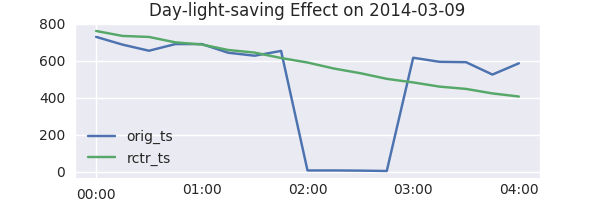

<IPython.core.display.Javascript object>


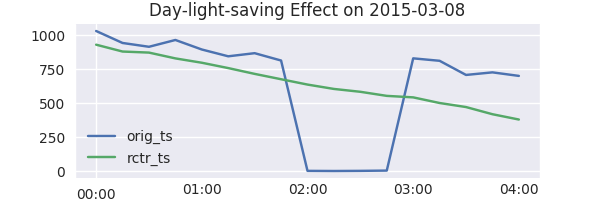

<IPython.core.display.Javascript object>


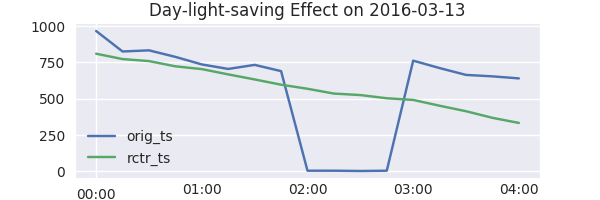

In [123]:
def plot_anomaly(anomaly_df, start_time, end_time, anomaly_description):
    ax = anomaly_df[start_time: end_time][['orig_ts','rctr_ts']]\
    .plot(figsize=(6,2), 
          title=anomaly_description)

plot_anomaly(anomaly_df,
             '2014-03-09 00:00:00', 
             '2014-03-09 04:00:00',
             'Day-light-saving Effect on 2014-03-09')
plot_anomaly(anomaly_df,
             '2015-03-08 00:00:00', 
             '2015-03-08 04:00:00',
             'Day-light-saving Effect on 2015-03-08')
plot_anomaly(anomaly_df,
             '2016-03-13 00:00:00', 
             '2016-03-13 04:00:00',
             'Day-light-saving Effect on 2016-03-13')

(2) During New Year's Eve, people should have been counting down to the next year at Time Square.

<IPython.core.display.Javascript object>


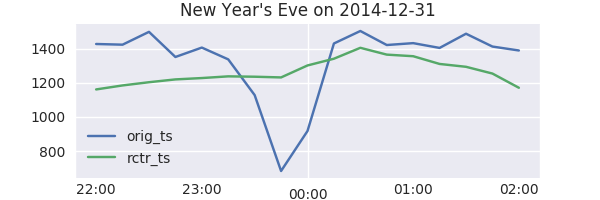

In [118]:
plot_anomaly(anomaly_df,
             '2014-12-31 22:00:00',
             '2015-01-01 02:00:00', 
             "New Year's Eve on 2014-12-31")

(3) Too-few-pickups anomally caused by some other reasons. The following plot shows a too-few-pickups anomaly pattern which happened during the midnight of a Saturday in 2015(2015-05-02). This pattern is very similar to that of the New Year's Eve. If given more time, I would like to search deeper online to understand what might be the cause of this anomaly.

<IPython.core.display.Javascript object>


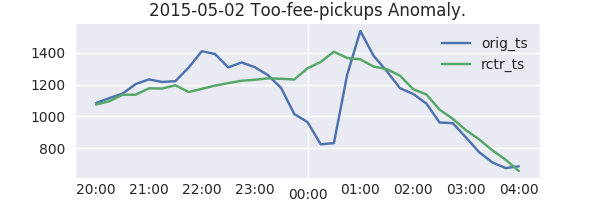

In [124]:
plot_anomaly(anomaly_df,
             '2015-05-02 20:00:00',
             '2015-05-03 04:00:00', 
             '2015-05-02 Too-few-pickups Anomaly')

#### b. The too-many-pickups anomaly.

In [58]:
too_many_pickups

,error,orig_ts,rctr_ts
2014-11-02 01:00:00,520.021419,1461,940.978581
2014-11-02 01:15:00,488.728848,1378,889.271152
2014-11-02 01:30:00,424.406242,1304,879.593758
2014-11-02 01:45:00,425.789098,1256,830.210902
2015-01-01 03:45:00,425.830448,1187,761.169552
2015-01-01 04:00:00,419.496817,1118,698.503183
2015-11-01 01:00:00,904.519036,2258,1353.480964
2015-11-01 01:15:00,860.952734,2167,1306.047266
2015-11-01 01:30:00,890.211827,2177,1286.788173
2015-11-01 01:45:00,834.839291,2078,1243.160709


(1) After Halloween Parties (2014 and 2015), people start to go home.

<IPython.core.display.Javascript object>


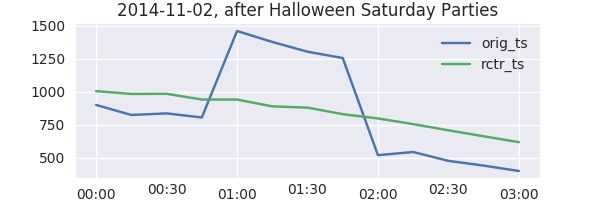

<IPython.core.display.Javascript object>


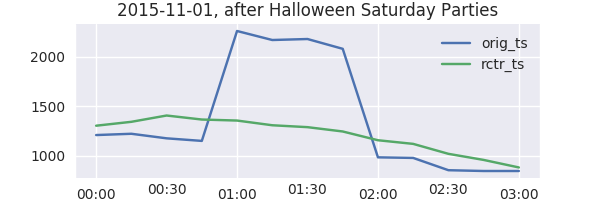

In [115]:
plot_anomaly(anomaly_df,
             '2014-11-02 00:00:00', 
             '2014-11-02 03:00:00',
             '2014-11-02, after Halloween Saturday Parties')
plot_anomaly(anomaly_df,
             '2015-11-01 00:00:00', 
             '2015-11-01 03:00:00',
             '2015-11-01, after Halloween Saturday Parties')

(2) In the Friday afternoon before the July 4th independence day (2016), people may have different travel plans than usual.

<IPython.core.display.Javascript object>


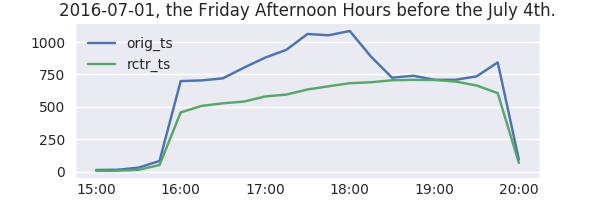

In [114]:
plot_anomaly(anomaly_df,
             '2016-07-01 15:00:00', 
             '2016-07-01 20:00:00',
             '2016-07-01, the Friday Afternoon Hours before the July 4th.')

(3) Just after the big storm on 2016-07-14, people call taxi to avoid walking to public transportation stations under rain. 

<IPython.core.display.Javascript object>


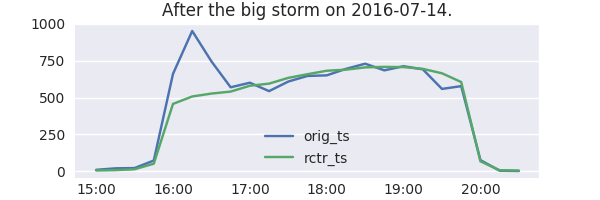

In [116]:
plot_anomaly(anomaly_df,
             '2016-07-14 15:00:00', 
             '2016-07-14 20:30:00',
             'After the big storm on 2016-07-14.')